# Book Recommendation

Using the goodbooks kaggle dataset to create a book recommendation system

In [97]:
pip install python-Levenshtein

In [98]:
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from Levenshtein import ratio

# Data Information

In [99]:
books = pd.read_csv('books.csv', on_bad_lines='skip')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [100]:
print("Oldest book: ", books['original_publication_year'].min())
print("Newer book: ", books['original_publication_year'].max())

Oldest book:  -1750.0
Newer book:  2017.0


In [101]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [102]:
btags = pd.read_csv('book_tags.csv')
btags.tail()

,goodreads_book_id,tag_id,count
999907,33288638,21303,7
999908,33288638,17271,7
999909,33288638,1126,7
999910,33288638,11478,7
999911,33288638,27939,7


In [103]:
tags = pd.read_csv('tags.csv')
tags.tail()

,tag_id,tag_name
34247,34247,Ｃhildrens
34248,34248,Ｆａｖｏｒｉｔｅｓ
34249,34249,Ｍａｎｇａ
34250,34250,ＳＥＲＩＥＳ
34251,34251,ｆａｖｏｕｒｉｔｅｓ


In [104]:
print("Is there NaN values? \nbooks dataset:",  books.isnull().values.any(),
      "\nratings dataset:", ratings.isnull().values.any(),
     "\ntags dataset:", btags.isnull().values.any(),
     "\nbook_tags dataset:", tags.isnull().values.any())

Is there NaN values? 
books dataset: True 
ratings dataset: False 
tags dataset: False 
book_tags dataset: False


In [105]:
null_count = books.isnull().sum()
null_count[null_count>0]

,0
isbn,700
isbn13,585
original_publication_year,21
original_title,585
language_code,1084


## Cleaning the data

Sorting user ratings and eliminating duplicate entries.

In [106]:
ratings = ratings.sort_values("user_id")
ratings.head()

,book_id,user_id,rating
117889,1180,1,4
488112,4893,1,3
625717,6285,1,4
796318,8034,2,4
875008,8855,2,5


In [107]:
ratings.drop_duplicates(subset=["user_id","book_id"], keep = False, inplace = True)
books.drop_duplicates(subset = 'original_title', keep=False, inplace=True)
tags.drop_duplicates(subset='tag_id', keep=False, inplace=True)
btags.drop_duplicates(subset=['goodreads_book_id', 'tag_id'], keep=False, inplace=True)

## Data Exploration and Analysis

Displaying the most frequent ratings, the distribution of ratings per book, and the relationship between ratings and other statistical factors.

In [108]:
books[['book_id','original_publication_year','average_rating','ratings_count']].describe()

,book_id,original_publication_year,average_rating,ratings_count
count,9.151000e+03,9145.000000,9151.000000,9.151000e+03
mean,4.869336e+06,1981.138218,3.999263,5.537463e+04
std,7.339193e+06,154.608318,0.252293,1.576800e+05
min,1.000000e+00,-1750.000000,2.470000,2.716000e+03
25%,4.329000e+04,1989.000000,3.850000,1.369100e+04
50%,3.307600e+05,2004.000000,4.020000,2.166200e+04
75%,8.069682e+06,2010.000000,4.170000,4.251100e+04
max,3.328864e+07,2017.000000,4.820000,4.780653e+06


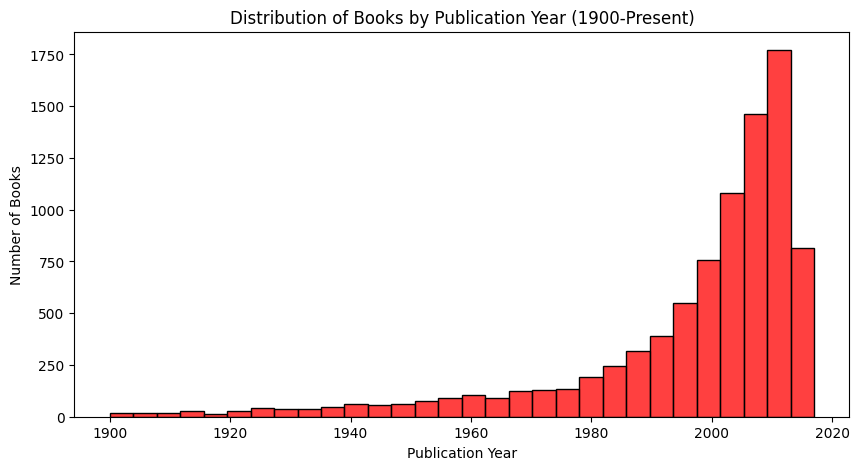

In [109]:
def plot_year_distribution():
    years_filtered = books[books['original_publication_year'] >= 1900]
    plt.figure(figsize=(10, 5))
    sns.histplot(years_filtered['original_publication_year'], bins=30, color='red')
    plt.xlabel("Publication Year")
    plt.ylabel("Number of Books")
    plt.title("Distribution of Books by Publication Year (1900-Present)")
    plt.show()
plot_year_distribution()

<ipython-input-110-9d831dcfb212>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=ratings, x ='rating', palette='pastel')


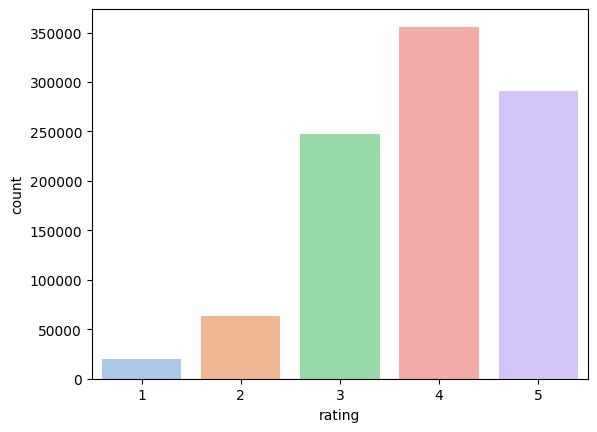

In [110]:
sns.countplot(data=ratings, x ='rating', palette='pastel')
plt.show()

### Most Common Ratings

> Add blockquote



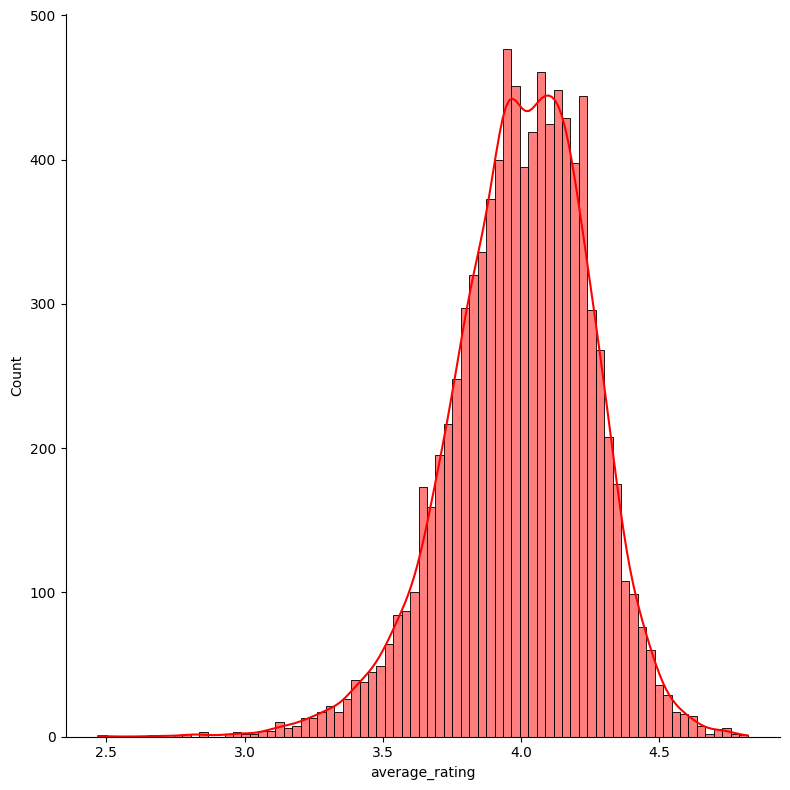

In [111]:
sns.displot(data=books, x='average_rating', kde=True, color='r', height=8)

We see that most books have a rating between 3.5 and 4.0

### Number of ratings per book

In [112]:
r = ratings.groupby(['book_id']).count()
r = r.sort_values(by='rating', ascending=False)
r.head()

,user_id,rating
book_id,,
1,100,100
4842,100,100
4870,100,100
4869,100,100
4868,100,100


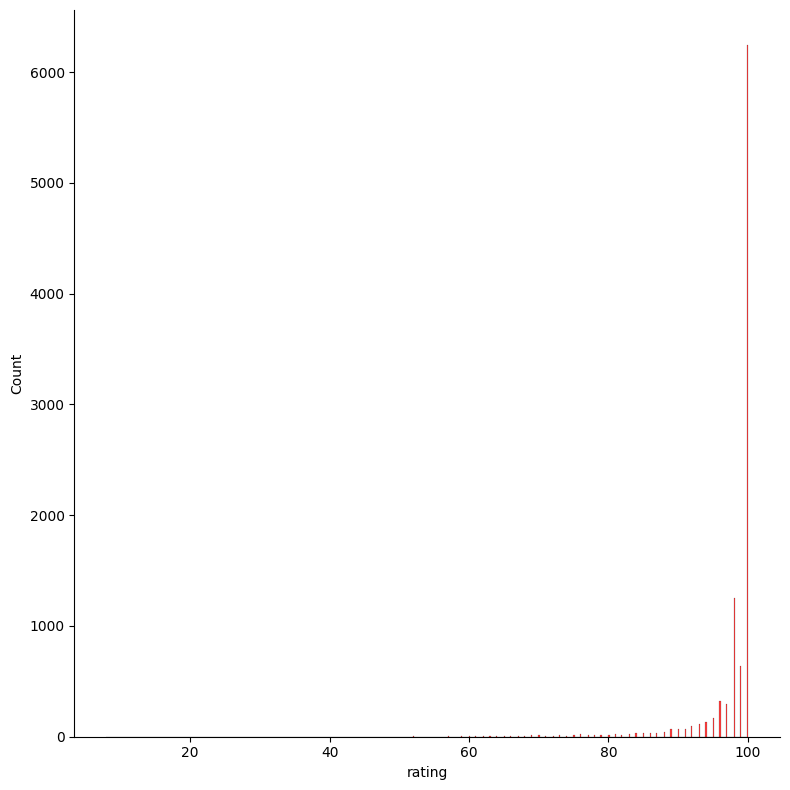

In [113]:
sns.displot(data=r, x='rating', color='r', height=8)

Most books have over 80 reviews in this datsa set

### Checking Correlation Between Ratings and Other Factors

---



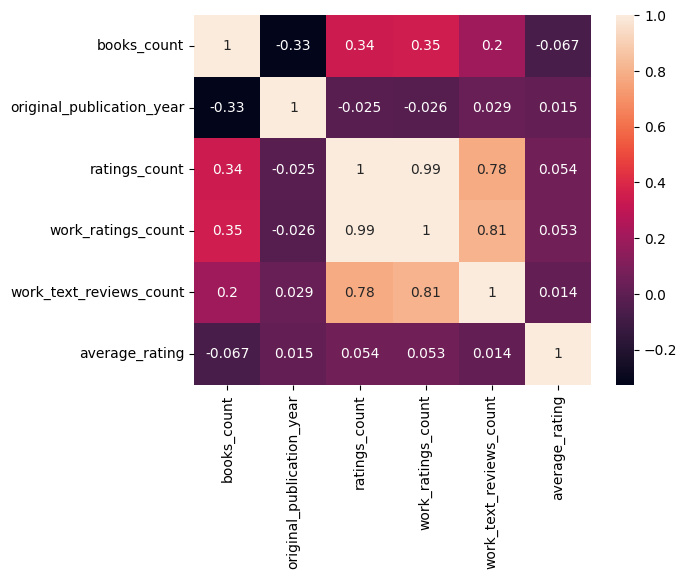

In [114]:
corrs = books[["books_count","original_publication_year","ratings_count", "work_ratings_count", "work_text_reviews_count", "average_rating"]].corr()
sns.heatmap(corrs, annot=True)
plt.show()

It appears that none of the other attributes of the book are closely correlated to the average rating, suggesting that the rating is based off of another factor, such as the quality of the book. Thus, our system cannot rely on any of the factors seen above

## Content Based Filtering System

This recommendation system suggests books by analyzing their title, author, tags, and average rating, utilizing KNN and cosine similarity for comparison.It involves handling missing data, standardizing text by converting it to lowercase, and extracting key features for accurate recommendations.

In [115]:
cleanbooks = books.fillna('')

def clean(word):
    return str.lower(word)

features = ['original_title','authors','average_rating', 'book_id']
cleanbooks = cleanbooks[features].astype(str)

for feature in features:
    cleanbooks[feature] = cleanbooks[feature].apply(clean)

Merging the dataframes that link tag_id to book titles and tag names, then identifying the most frequently used tags. Since these tags are user-generated, only the most relevant ones will be selected for the system.

In [116]:
joint_tags = pd.merge(btags, tags, left_on='tag_id', right_on='tag_id', how='inner')

p = joint_tags.groupby('tag_name').count()
p = p.sort_values(by='count', ascending=False)

pd.set_option('display.max_rows', 10)
p.head(10)

,goodreads_book_id,tag_id,count
tag_name,,,
to-read,9983,9983,9983
favorites,9881,9881,9881
owned,9856,9856,9856
books-i-own,9799,9799,9799
currently-reading,9776,9776,9776
library,9415,9415,9415
owned-books,9221,9221,9221
fiction,9097,9097,9097
to-buy,8692,8692,8692


From above, we choose the following genres and drop all the other tags from the data.

In [117]:
genres = ['fiction', 'adult', 'series', 'adult-fiction', 'fantasy', 'romance', 'novel', 'mystery', 'adventure',
         'young-adult', 'drama', 'ya', 'classics', 'contemporary-fiction', 'historical-fiction', 'historical',
          'thriller', 'sci-fi-fantasy', 'suspense', 'sci-fi', 'science-fiction', 'action', 'humor', 'family',
         'non-fiction', 'crime', 'paranormal', 'classic', 'mystery-thriller', 'teen', 'supernatural', 'nonfiction',
         'realistic-fiction', 'literary-fiction', 'funny', 'scifi-fantasy', 'ya-fiction', 'mystery-suspense',
         'mysteries', 'horror', 'thrillers', 'young-adult-fiction', 'ya-books', 'scifi']

new_joint = joint_tags[joint_tags.tag_name.isin(genres)]
new_joint

,goodreads_book_id,tag_id,count,tag_name
1,1,11305,37174,fantasy
4,1,33114,12716,young-adult
5,1,11743,9954,fiction
9,1,32989,4364,ya
10,1,27199,3857,series
...,...,...,...,...
999826,33288638,11743,21,fiction
999848,33288638,11221,13,family
999853,33288638,15048,12,humor
999861,33288638,9886,10,drama


Now we combine all the tags for each book, rename the book id column, and ensure we have one row per book.

In [118]:
combined = new_joint[['goodreads_book_id', 'tag_name']].copy()
combined['tag_name'] = combined.groupby(['goodreads_book_id'])['tag_name'].transform(lambda x : ' '.join(x))
combined.rename(columns={'goodreads_book_id' : 'book_id'}, inplace=True)

In [119]:
final_tags = pd.DataFrame.drop_duplicates(combined)
final_tags = final_tags.astype(str)
final_tags

,book_id,tag_name
1,1,fantasy young-adult fiction ya series adventur...
102,2,fantasy fiction young-adult paranormal teen su...
202,3,fantasy young-adult fiction ya series adventur...
299,5,fantasy young-adult fiction ya series adventur...
398,6,fantasy young-adult fiction ya series adventur...
...,...,...
999398,31538647,fantasy fiction young-adult series ya sci-fi-f...
999499,31845516,non-fiction nonfiction adult family fiction
999597,32075671,young-adult fiction realistic-fiction ya teen ...
999697,32848471,funny adult humor romance drama adult-fiction ...


Adding a new column containing the book ***title, author, average rating and tags*** as a string.

In [120]:
def create_str(x):
    mstr = x['original_title'] + x['authors'] + x['average_rating'] + x['tag_name']
    return mstr

book_info = pd.merge(cleanbooks, final_tags, left_on='book_id', right_on='book_id', how='inner')
book_info['book_str'] = book_info.apply(create_str, axis=1)
book_info.head(10)

,original_title,authors,average_rating,book_id,tag_name,book_str
0,the hunger games,suzanne collins,4.34,2767052,young-adult fiction fantasy ya science-fiction...,the hunger gamessuzanne collins4.34young-adult...
1,harry potter and the philosopher's stone,"j.k. rowling, mary grandpré",4.44,3,fantasy young-adult fiction ya series adventur...,harry potter and the philosopher's stonej.k. r...
2,to kill a mockingbird,harper lee,4.25,2657,classics classic historical-fiction young-adul...,to kill a mockingbirdharper lee4.25classics cl...
3,the great gatsby,f. scott fitzgerald,3.89,4671,classics fiction classic historical-fiction ro...,the great gatsbyf. scott fitzgerald3.89classic...
4,the fault in our stars,john green,4.26,11870085,young-adult fiction ya romance realistic-ficti...,the fault in our starsjohn green4.26young-adul...
5,the hobbit or there and back again,j.r.r. tolkien,4.25,5907,fantasy classics fiction classic adventure you...,the hobbit or there and back againj.r.r. tolki...
6,the catcher in the rye,j.d. salinger,3.79,5107,classics fiction classic young-adult ya novel ...,the catcher in the ryej.d. salinger3.79classic...
7,angels & demons,dan brown,3.85,960,fiction mystery thriller suspense series adven...,angels & demons dan brown3.85fiction mystery t...
8,pride and prejudice,jane austen,4.24,1885,classics fiction romance classic historical-fi...,pride and prejudicejane austen4.24classics fic...
9,the kite runner,khaled hosseini,4.26,77203,fiction historical-fiction classics adult adul...,the kite runner khaled hosseini4.26fiction his...


Vectorizing the book string and computing a *cosine similarity matrix* across the books, and getting the book indicies to use later.

In [121]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(book_info['book_str'])

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

book_info = book_info.reset_index()
indices = pd.Series(book_info.index, index=book_info['original_title'])

A function that generates book recommendations by utilizing the precomputed cosine similarity scores.

In [122]:
def get_recs(title, cosine_sim = cosine_sim2):
    title = title.lower()
    idx = indices[title]

    # similarity scores of books with the inputted book
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    book_indices = [i[0] for i in sim_scores]
    # Return the top 10 most similar books
    return list(books['original_title'].iloc[book_indices])

Evaluating the recommendation system using well-known books

In [123]:
test = get_recs('Pride and Prejudice', cosine_sim2)

for book in test:
    print(book)

Great Expectations
My Ántonia
Ethan Frome
Ivanhoe
The Grapes of Wrath
The Great Gatsby
Good Wives
Maurice
The Sea Wolf
How Green Was My Valley


In [124]:
test = get_recs("Divergent", cosine_sim2)

for book in test:
    print(book)

Insurgent
Four: The Transfer
The Fall of Five
The Testing
Starters
UnDivided
Allegiant
Pretties
Crossed
The Ask and the Answer


# Collaborative Filtering System


Collaborative filtering generates book recommendations by analyzing user ratings and identifying similar users based on their preferences.

To optimize the dataset, only the necessary columns are selected, and any missing data is removed.

In [125]:
books_col = books[['book_id', 'original_title']]
books_col.dropna()

,book_id,original_title
0,2767052,The Hunger Games
1,3,Harry Potter and the Philosopher's Stone
3,2657,To Kill a Mockingbird
4,4671,The Great Gatsby
5,11870085,The Fault in Our Stars
...,...,...
9995,7130616,Bayou Moon
9996,208324,Means of Ascent
9997,77431,The Mauritius Command
9998,8565083,Cinderella Ate My Daughter: Dispatches from th...


In [126]:
# Calculating the number of unique users and books
num_users = ratings['user_id'].nunique()
num_books = ratings['book_id'].nunique()
num_ratings = ratings.shape[0]

print('Number of unique users:', num_users)
print('Number of unique books:', num_books)
print('Number of ratings:', num_ratings)

Number of unique users: 53380
Number of unique books: 10000
Number of ratings: 977269


In [127]:
ratings_cleaned = ratings.dropna()
rating_distribution = ratings_cleaned.groupby('rating').size().to_frame(name='count')

# Calculating the number of missing ratings (unrated books)
total_possible_ratings = num_users * num_books
unrated_count = total_possible_ratings - ratings_cleaned.shape[0]

rating_counts = pd.concat([rating_distribution, pd.DataFrame({'count': unrated_count}, index=[0.0])]).sort_index()
rating_counts

,count
0.0,532822731
1.0,19485
2.0,63010
3.0,247698
4.0,355878
5.0,291198


Since many books have not received ratings from users, they need to be excluded. To maintain sufficient data for the model, only books with more than 50 ratings and users who have rated at least 30 books will be considered.

Getting the number of ratings per book:

In [128]:
df_books_cnt = pd.DataFrame(ratings.groupby('book_id').size(), columns=['count'])

In [129]:
df_books_cnt

,count
book_id,
1,100
2,100
3,100
4,100
5,100
...,...
9996,96
9997,89
9998,95


Dropping books with under 50 ratings

In [130]:
# Setting a threshold for popular books
book_threshold = 50
popular_books = set(df_books_cnt[df_books_cnt['count'] >= book_threshold].index)

# Filtering ratings to include only popular books
df_ratings_filtered = ratings[ratings.book_id.isin(popular_books)]

# Displaying the number of ratings before and after filtering
print('Total number of book ratings before filtering:', ratings.shape[0])
print('Number of ratings after removing unpopular books:', df_ratings_filtered.shape[0])

Total number of book ratings before filtering: 977269
Number of ratings after removing unpopular books: 976884


Getting the number of ratings per user

In [131]:
df_users_cnt = pd.DataFrame(df_ratings_filtered.groupby('user_id').size(), columns=['count'])

In [132]:
df_users_cnt

,count
user_id,
1,3
2,3
3,2
4,3
5,5
...,...
53420,6
53421,8
53422,18


Dropping users that have rated under 50 books

In [133]:
# Defining a threshold for active users
user_threshold = 30
active_users = set(df_users_cnt[df_users_cnt['count'] >= user_threshold].index)

# Filtering ratings to include only active users
df_ratings_filtered = df_ratings_filtered[df_ratings_filtered.user_id.isin(active_users)]

# Displaying the number of ratings before and after filtering
print('Total number of book ratings before filtering:', ratings.shape[0])
print('Number of ratings after removing less active users and unpopular books:', df_ratings_filtered.shape[0])

Total number of book ratings before filtering: 977269
Number of ratings after removing less active users and unpopular books: 601798


In [134]:
book_user_mat = df_ratings_filtered.pivot(index='book_id', columns='user_id', values='rating').fillna(0)

In [135]:
book_user_mat_sparse = csr_matrix(book_user_mat.values)
book_user_mat_sparse

<9984x9737 sparse matrix of type '<class 'numpy.float64'>'
	with 601798 stored elements in Compressed Sparse Row format>

Create the KNN model using sklearn.neighbors and fit to the sparse matrix

---



In [136]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

model_knn.fit(book_user_mat_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

**Levenshtein distance**

The given code defines a Levenshtein-based matching function that helps find the closest matching book title in a dataset.

In [137]:
indices = pd.Series(books_col.index, index=books_col['original_title'])

def levenshtein_matching(mapper, fav_book, verbose=True):
    match_tuple = []

    for title, idx in mapper.items():
        similarity = ratio(title.lower(), fav_book.lower())
        if similarity >= 0.6:
            match_tuple.append((title, idx, similarity))

    match_tuple = sorted(match_tuple, key=lambda x: x[2], reverse=True)
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

In [138]:
def make_recommendation(model_knn, data, mapper, title, n_recommendations):
    print('You have input book:', title)
    idx = levenshtein_matching(mapper, title)

    print('Recommendation system starting to make inference...')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)

    raw_recommends = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    reverse_mapper = {v: k for k, v in mapper.items()}

    print('Recommendations for {}:'.format(title))
    rec=[]
    for i, (idx, dist) in enumerate(raw_recommends):
        if idx not in reverse_mapper.keys():
            continue
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))
        rec.append(reverse_mapper[idx])
    return rec

In [139]:
def make_recommendation(model_knn, data, mapper, title, n_recommendations):
    print('You have input book:', title)
    idx = levenshtein_matching(mapper, title)

    print('Recommendation system starting to make inference...')
    indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)[1]

    raw_recommends = sorted(list(indices.squeeze().tolist()))[:n_recommendations]  # Ensure correct sorting
    reverse_mapper = {v: k for k, v in mapper.items()}

    print('Recommendations for ({}):'.format(title))
    for i, idx in enumerate(raw_recommends):
        if idx not in reverse_mapper:
            continue
        print(f"{i+1}: {reverse_mapper[idx]}")  # Display only rank and title


In [140]:
make_recommendation(model_knn=model_knn, data=book_user_mat_sparse, title="The Maze Runner",mapper=indices,
                    n_recommendations=10)

You have input book: The Maze Runner
Found possible matches in our database: ['The Maze Runner', 'The Kite Runner ', 'Once a Runner', 'The Partner', 'The Pale Rider', 'The Mime Order', 'The Maze of Bones ', 'The Miracle Worker', 'The Lace Reader', 'The Wanderer', 'The Mammoth Hunters', 'The False Prince', 'The Smoke Jumper', 'The Dream Hunter', 'The Chaperone', 'The Persuader', 'The Naked Sun', 'The Passenger', 'The Winner', 'The Sinner', "She's Come Undone", 'The Faerie Queene', 'The Gunslinger', 'The Art Forger', 'The Gate House', 'The Mane Event', 'The Martian', 'Three Junes', 'The Panther', 'The Painter', 'The Haunted', 'The Darkest Surrender', 'The Omen', 'The Immortal Rules', 'The Time Keeper', 'The Naked Lunch', 'The ABC Murders', 'The Sympathizer', 'The Bonehunters', 'The Gatecrasher', 'The Water Knife', 'The Summer Tree', 'The Fixer Upper', 'The Breadwinner', 'The Hate U Give']

Recommendation system starting to make inference...
Recommendations for (The Maze Runner):
1: The F

In [141]:
make_recommendation(model_knn=model_knn, data=book_user_mat_sparse, title="Wicked: The Life and Times of the Wicked Witch of the West",mapper=indices,
                    n_recommendations=10)

You have input book: Wicked: The Life and Times of the Wicked Witch of the West
Found possible matches in our database: ['Wicked: The Life and Times of the Wicked Witch of the West', 'Zealot: The Life and Times of Jesus of Nazareth']

Recommendation system starting to make inference...
Recommendations for (Wicked: The Life and Times of the Wicked Witch of the West):
1: The Hobbit or There and Back Again
2: Angels & Demons 
3: The Lovely Bones
4: An Excellent conceited Tragedie of Romeo and Juliet
6: Jurassic Park
7: Flickan som lekte med elden
8: Wicked: The Life and Times of the Wicked Witch of the West
9: Girl with a Pearl Earring
10: She's Come Undone


In [142]:
make_recommendation(model_knn=model_knn, data=book_user_mat_sparse, title="Ready Player One",mapper=indices,
                    n_recommendations=10)

You have input book: Ready Player One
Found possible matches in our database: ['Ready or Not', 'The Player of Games', 'Dead and Gone', 'Reaper Man']

Recommendation system starting to make inference...
Recommendations for (Ready Player One):
1: Neil Patrick Harris: Choose Your Own Autobiography
2: The Expats
3: And Another Thing... (Hitchhiker's Guide to the Galaxy, #6)
4: Law Man
6: Cleopatra's Daughter
7: The Onion Field
8: Dark Gold (Dark #3)
9: The Lost Prince
10: Ready or Not
